In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, None, 1)           65        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-traina

(1e-08, 0.0001, 0.0, 30.0)

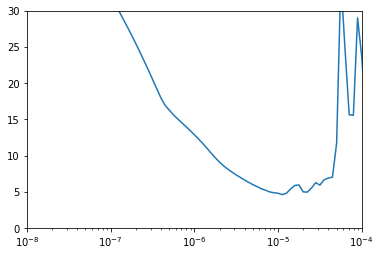

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

history = model.fit(dataset, epochs=500, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          128       
                                                                 
 lstm (LSTM)                 (None, None, 32)          8320      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________


In [8]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

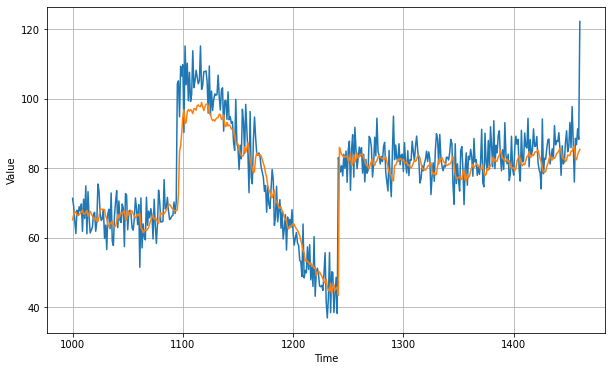

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.118321

<Figure size 432x288 with 0 Axes>

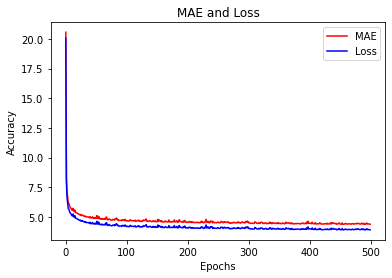

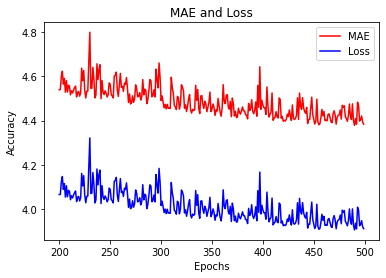

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))  # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Real data: Sunspots

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [15]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

C:\Users\Asus\anaconda3\envs\TF_Developer_Certificate\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: D:\TF-Developer-Certificate\TensorFlow in Practice - Course\Sequences-Time Series and Prediction\Sunspots.csv

  0%|          | 0.00/70.8k [00:00<?, ?B/s]
100%|##########| 70.8k/70.8k [00:00<00:00, 1.10MB/s]


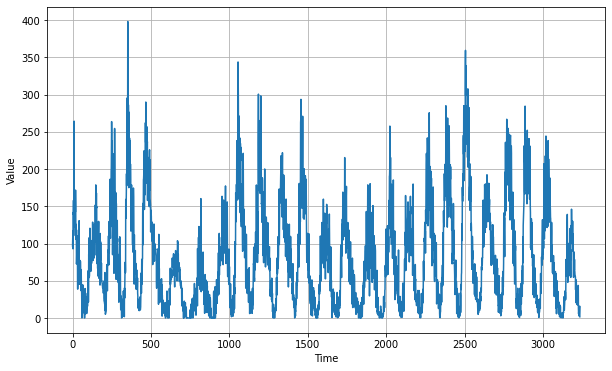

In [16]:
import csv

time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [17]:
split_time = 3000
window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = series[..., np.newaxis]
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # dataset = dataset.shuffle(shuffle_buffer).map(lambda x: (x[:-1], x[1:]))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    return dataset.batch(batch_size).prefetch(1)

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation='relu',
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

call_back = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

C:\Users\Asus\anaconda3\envs\TF_Developer_Certificate\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(1e-08, 0.0001, 0.0, 60.0)

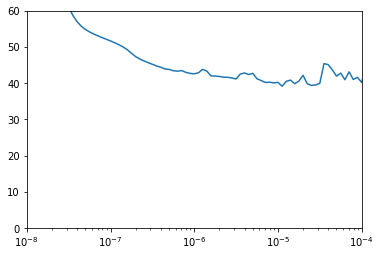

In [35]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation='relu',
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=["mae"])

history = model.fit(train_set, epochs=200, verbose=1)

Epoch 1/200
12/12 [==============================] - 12s 488ms/step - loss: 58.0485 - mae: 58.5466
Epoch 2/200
12/12 [==============================] - 6s 459ms/step - loss: 49.8735 - mae: 50.3713
Epoch 3/200
12/12 [==============================] - 5s 430ms/step - loss: 43.2955 - mae: 43.7926
Epoch 4/200
12/12 [==============================] - 5s 434ms/step - loss: 41.6694 - mae: 42.1665
Epoch 5/200
12/12 [==============================] - 5s 406ms/step - loss: 40.7472 - mae: 41.2442
Epoch 6/200
12/12 [==============================] - 5s 414ms/step - loss: 40.3094 - mae: 40.8063
Epoch 7/200
12/12 [==============================] - 5s 416ms/step - loss: 40.1045 - mae: 40.6014
Epoch 8/200
12/12 [==============================] - 5s 418ms/step - loss: 39.7334 - mae: 40.2302
Epoch 9/200
12/12 [==============================] - 5s 422ms/step - loss: 39.6951 - mae: 40.1921
Epoch 10/200
12/12 [==============================] - 5s 440ms/step - loss: 39.1836 - mae: 39.6805
Epoch 11/200
12/12

In [37]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

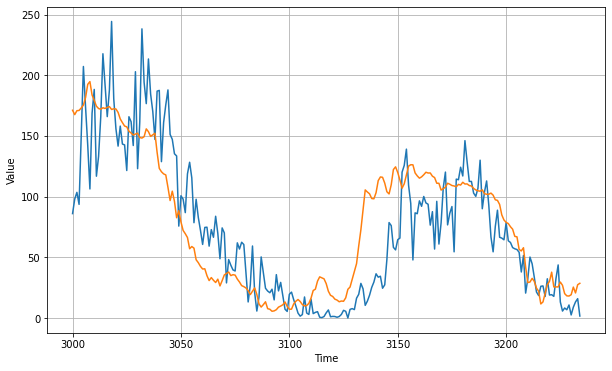

In [38]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [39]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

26.99519

ValueError: x and y must have same first dimension, but have shapes (300,) and (0,)

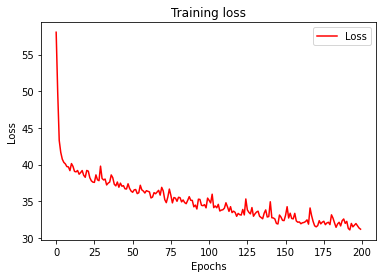

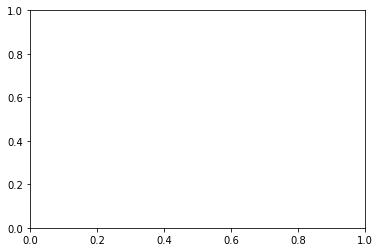

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()